In [1]:
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),               # Random crop + resize to 224x224
    transforms.RandomHorizontalFlip(),               # Randomly flip images horizontally
    transforms.ColorJitter(0.2, 0.2, 0.2),            # Random brightness, contrast, saturation
    transforms.RandomRotation(15),                   # Randomly rotate images
    transforms.ToTensor(),                           # Convert image to tensor
    transforms.Normalize(                            # Normalize using ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Only resize and center crop for validation
val_transform = transforms.Compose([
    transforms.Resize(256),                          # Resize shortest side to 256
    transforms.CenterCrop(224),                      # Center crop to 224x224
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(                            # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

data_path = "Downloads/archive/PetImages"  # Make sure this path is correct

# Load full dataset without transform for now
full_dataset = ImageFolder(root=data_path)

# Split dataset into train/val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transforms to each split manually (this is critical!)
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

print(f"Total images: {len(full_dataset)}")
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Class names: {full_dataset.classes}")

Total images: 24998
Training set: 19998 images
Validation set: 5000 images
Class names: ['Cat', 'Dog']


In [4]:
from torch.utils.data import DataLoader

batch_size = 32  # Adjust depending on memory

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Peek at a batch
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")  # Expected: [32, 3, 224, 224]
print(f"Labels batch shape: {labels.shape}")
print(f"Labels: {labels}")

Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Labels: tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0])


In [ ]:
# Defining the model
import torch.nn as nn
import torch.optim as optim

# Define CNN model with dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):   #classes caan be changed; think of the function as a blueprint
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.6)  # Dropout for regularization
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))    # [B, 16, 112, 112]
        x = self.pool(self.relu(self.conv2(x)))    # [B, 32, 56, 56]
        x = x.view(x.size(0), -1)                  # Flatten: [B, 32*56*56]
        x = self.dropout(self.relu(self.fc1(x)))   # Apply dropout before FC2
        x = self.fc2(x)
        return x

# Instantiate model
model = SimpleCNN(num_classes=2).to(device)

# Loss and optimizer (with weight decay for L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [ ]:
#Definining the ResNet18-based model with frozen backbone
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet18
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers to prevent their weights from updating during training
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match our 2-class task
num_features = resnet18.fc.in_features

#print model summary
print(model)

In [ ]:
# Definining loss function and optimizer for training the final layer(Resnet)

import torch.optim as optim
import torch.nn as nn

# Loss function: CrossEntropyLoss is standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: Only optimize the unfrozen final layer (fc)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) #learning rate(can be modified); higher rate(1e-2) makes model learn faster but more unstable


In [ ]:
# Training and validation loop for the ResNet18 model

import time
import torch

num_epochs = 50  # Adjust as needed

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)

    # -------------------------
    # Validation phase
    # -------------------------
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = 100 * correct / total
    elapsed_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Acc: {epoch_val_acc:.2f}%, "
          f"Time: {elapsed_time:.1f}s")


In [ ]:
# Cell – Save the trained model's weights

import os
import torch

# Create a folder (if it doesn't exist) to keep things organized
os.makedirs("models", exist_ok=True)

# Save only the model's learned parameters (recommended PyTorch practice)
model_path = "models/resnet18_cats_vs_dogs.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved to: {model_path}")

In [5]:
# Cell – Load the model weights into a fresh ResNet18 architecture

from torchvision.models import resnet18
import torch.nn as nn
import torch

# Rebuild the same architecture (must match what was trained)
model = resnet18(pretrained=False)  # Don't use pretrained, we are loading our own weights
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classifier

# Load the saved weights
model.load_state_dict(torch.load("models/resnet18_cats_vs_dogs.pth"))
model.eval()  # Set to evaluation mode

# Move to correct device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model loaded and ready for inference.")


/home/hipe2/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hipe2/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded and ready for inference.


In [6]:
# Run a quick test on one batch (just to confirm loading worked)
inputs, labels = next(iter(val_loader))
inputs = inputs.to(device)
outputs = model(inputs)

_, preds = torch.max(outputs, 1)

print("Predictions:", preds.cpu().numpy())


Predictions: [0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1]


In [7]:
# Function to evaluate the model's accuracy on a data loader
def evaluate_model(model, data_loader):
    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()
    correct = 0  # Track number of correct predictions
    total = 0    # Track total number of predictions

    # Disable gradient computation (saves memory and time)
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Move inputs and labels to the correct device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Run inference
            outputs = model(inputs)

            # Get predicted class (index of max logit for each example)
            _, preds = torch.max(outputs, 1)

            # Update count of correct predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Calculate and print accuracy
    acc = 100 * correct / total
    print(f"Final Model Accuracy: {acc:.2f}%")

# Call the evaluation function using your validation set
evaluate_model(model, val_loader)


Final Model Accuracy: 98.60%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.3088455].


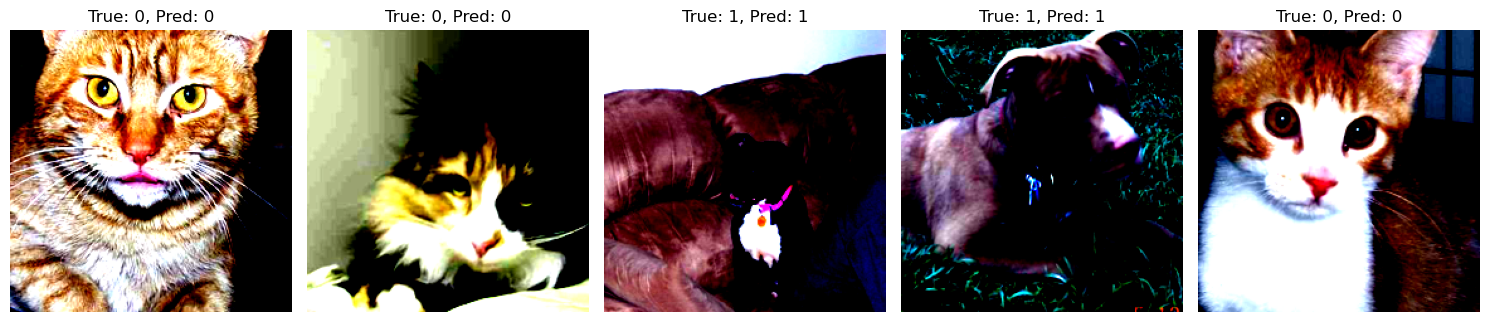

In [16]:
import matplotlib.pyplot as plt
import torchvision

# Helper function to show a few images along with predictions
def show_images(imgs, labels, preds):
    # Create a row of subplots
    fig, axes = plt.subplots(1, len(imgs), figsize=(15, 5))
    
    # Loop through images and show them with predicted/true labels
    for img, label, pred, ax in zip(imgs, labels, preds, axes):
        # Convert image from (C, H, W) to (H, W, C) and move to CPU
        ax.imshow(img.permute(1, 2, 0).cpu())
        ax.set_title(f"True: {label}, Pred: {pred}")  # Title with labels
        ax.axis('off')  # Hide axis ticks

    plt.tight_layout()
    plt.show()

# Get a single batch of validation data
inputs, labels = next(iter(val_loader))

# Move data to device (GPU or CPU)
inputs, labels = inputs.to(device), labels.to(device)

# Run inference
outputs = model(inputs)
_, preds = torch.max(outputs, 1)  # Get predicted class indices

# Show the first 5 images, with their true and predicted labels
show_images(inputs[:5], preds[:5].cpu().numpy(), labels[:5].cpu().numpy())
